# Experimentelle Modalanalyse (EMA) | Prof. J. Grabow
## MDOF (Systeme mit einem Freiheitsgrad f>1) und Rayleigh-Dämpfung
### modale Entkopplung

In [176]:
# -*- coding: utf-8 -*-
"""
Created on Fri Sep  1 19:13:41 2023

Program history
01.09.2023    V. 1.0    Start
09.10.2023    V. 1.1    Anfangsbedingungen
10.10.2023    V  1.2    Lösung des entkoppelten Systems im Zeitbereich
16.11.2023    V  1.3    Frequenzgang
22.11.2023    V  1.4    Dokumentation

@author: Prof. Jörg Grabow (grabow@amesys.de)
"""
__version__ = '1.4'
__author__ = 'Joe Grabow'

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from sympy import *
from sympy.physics.mechanics import dynamicsymbols, mlatex
from IPython.display import Math, Latex
from matplotlib.widgets import MultiCursor

### Hilfsfunktion normiere_matrix(matrix)
Normiert in einer Matrix in jedem Spaltenvektor den betragsmäßig größten Wert auf eins (Darstellungsnorm).

In [177]:
def normiere_matrix(matrix):
    """normiert in einer Matrix in jedem Spaltenvektor den betragsmäßig größten
    Wert auf eins"""
    max_abs_werte = np.max(np.abs(matrix), axis=0)
    normierte_matrix = matrix / max_abs_werte
    return normierte_matrix

### Hilfsfunktion zur Berechnung des komplexen Frequenzganges

In [178]:
def frf(ordnung,i,k,omega_e):
    # Estimate the frequency-response functions of the model.
    # erzeuge komplexen Null-Vektor in Länge des Vektors der Erregerfrequenz
    f_vektor = np.zeros(len(omega_e), dtype=complex)
    for n in range(ordnung):
        S_1 = (Residuum[n] * phi[i,n] * phi[k,n]) / \
            ((0+1j) * omega_e - eigenwert_k[n])
        S_2 = (np.conj(Residuum[n]) * phi[i,n] * phi[k,n]) / \
            ((0+1j) * omega_e - np.conj(eigenwert_k[n] ))
        f_vektor = f_vektor + S_1 + S_2
    return f_vektor

## Definition der Systemparameter
Alle Systemparameter wie Massen, Steifigkeiten oder Dämpfungen werden in SI-Einheiten angegeben.

In [179]:
# Eingabe der Systemmatrizen M,C,K
m1, m2, m3 = (60e3, 60e3, 15e3)
c1, c2, c3 = (30e6, 30e6, 10e6)
k1, k2, k3 = (100, 250, 80)
alpha, beta = 0.9, 1e-4

## Definition der Systemmatrizen
Eingabe der Massenmatrix, Steifigkeitsmatrix und Dämpfungsmatrix

### Eingabe der Matrizen und Anfangsbedingungen
---
- *M - Massenmatrix als Array*
- *C - Steifigkeitsmatrix als Array*
- *K - Dämfungsmatrix als Array*
---
Bei proportionaler Dämpfung (Rayleigh-Dämpfung): $K = \alpha M + \beta C$.

In [180]:
M = np.array([[m1, 0, 0],
              [0, m2, 0],
              [0, 0, m3]])
C = np.array([[c1+c2, -c2,   0],
              [-c2, c2+c3, -c3],
              [0, -c3,  c3]])
K = np.array([[k1+k2, -k2,   0],
              [-k2, k2+k3, -k3],
              [0, -k3,  k3]])
# nur bei Rayleigh-Dämpfung
K = alpha*M + beta*C

## Systemmatrizen
### Massenmatrix

In [181]:
Math(rf'M = {sym.latex(Matrix(M))}')

<IPython.core.display.Math object>

### Steifigkeitsmatrix

In [182]:
Math(rf'C = {sym.latex(Matrix(C))}')

<IPython.core.display.Math object>

### Dämpfungsmatrix

In [183]:
Math(rf'K = {sym.latex(Matrix(K))}')

<IPython.core.display.Math object>

In [184]:
# verallgemeinerte Koordinaten q(t)
q1, q2, q3 = dynamicsymbols('q1 q2 q3')
Q = sym.Matrix([[q1],[q2],[q3]])

# Erregerkräfte f(t)
f1, f2, f3 = dynamicsymbols('f1 f2 f3')
F = sym.Matrix([[f1],[f2],[f3]])

# Zeitableitungen der verallgemeinerten Koordinaten q(t)
Qd = Q.diff(t,1)
Qdd = Q.diff(t,2)

### Dgl.-System

In [185]:
display(Math(sym.latex(Matrix(M))+mlatex(Qdd)+'+'+sym.latex(Matrix(C))+mlatex(Qd)+sym.latex(Matrix(K))+mlatex(Q)+'='+mlatex(F)))

<IPython.core.display.Math object>

 ### Anfangsbedingungen $q_{o}$ und $v_{0}$

In [186]:
# Anfangsbedingungen
q_0 = np.array([1e-3, -2e-3, 0.5e-3])  # Anfangsweg in mm
v_0 = np.array([0.5e-3, 1e-3, -0.5e-3])  # Anfangsgeschwindigkeit in mm/s

## Berechnungen zur Entkopplung des Dgl.-Systems
### Die Systemmatrix A: 

$A = M^{-1} \cdot C$

In [187]:
A = np.matmul(np.linalg.inv(M),C)

### Das spezielle Eigenwertproblem
$\left( A - \lambda \cdot E \right) \cdot \psi = 0$ 

$det \left( A - \lambda E \right) = 0$

In [188]:
eigenwerte, eigenvektoren = np.linalg.eig(A)

# Sortiere die Eigenwerte und -vektoren nach den Eigenwerten
sort_indices = np.argsort(eigenwerte)[::-1]
sortierte_eigenwerte = eigenwerte[sort_indices]
sortierte_eigenvektoren = eigenvektoren[:, sort_indices]

Eigenkreisfrequenzen (ungedämpft) sortiert nöch Größe:

$\omega _0 = \sqrt{ \lambda }$

In [189]:
wn = np.sqrt(sortierte_eigenwerte)
wn

array([37.62931365, 27.62475937, 12.41937023])

zugehörige Eigenvektoren $\psi$ und die Eigenvektormatrix $\Psi$

In [190]:
sortierte_eigenvektoren

array([[ 0.66815554, -0.28934219, -0.3389505 ],
       [-0.55585897, -0.13707452, -0.57334103],
       [ 0.49455938,  0.94736037, -0.7459173 ]])

In [191]:
ordnung = len(wn)

### Normierung der Eigenvektoren
In jedem Eigenvektor wird der betragsmäßig größte Wert immer auf eins normiert.

normierte Eigenvektoren $\psi_{N}$

In [192]:
psi = normiere_matrix(sortierte_eigenvektoren)
psi

array([[ 1.        , -0.30541935, -0.45440761],
       [-0.83193049, -0.144691  , -0.76863886],
       [ 0.74018601,  1.        , -1.        ]])

### Die generalisierte Massenmatrix $M_G$
generalisierte Massenmatrix:

$M_G = \Psi ^T M \Psi$

In [193]:
psiT = np.transpose(psi)
MG = np.dot(np.dot(psiT,M),psi)
np.around(MG,2)

array([[109744.63,     -0.  ,     -0.  ],
       [    -0.  ,  21852.99,     -0.  ],
       [    -0.  ,     -0.  ,  62837.52]])

### Die Modalmatrix $\phi$
Normierung der Eigenvektoren $\psi \text{  auf  } \phi$

$\phi ^{(i)} = \frac{\psi ^{(i)}} { \sqrt{{M_G}_{i,i} } }$

In [194]:
phi = psi/(np.sqrt(np.diag(MG)))

Modalmatrix $\Phi$

In [195]:
phi

array([[ 0.00301862, -0.00206605, -0.00181274],
       [-0.00251128, -0.00097878, -0.00306629],
       [ 0.00223434,  0.00676464, -0.00398924]])

Proberechnung

$\Phi^{T} \cdot M \cdot \Phi = E$

In [196]:
E = np.dot(np.dot(np.transpose(phi),M),phi)
np.around(E,2)

array([[ 1., -0., -0.],
       [-0.,  1., -0.],
       [-0., -0.,  1.]])

### Die modale Dämpfungsmatrix $K_m$
$K_m =\Phi^T \cdot K \cdot \Phi$


In [197]:
Km = np.dot(np.dot(np.transpose(phi),K),phi)
np.around(Km,4)

array([[ 1.0416, -0.    , -0.    ],
       [-0.    ,  0.9763, -0.    ],
       [-0.    , -0.    ,  0.9154]])

### Die Lehrschen Dämpfungsmaße D
$D_i = \frac{ {K_m}_{i,i} }{2 \cdot {\omega_0}_i  }$

In [198]:
D = np.diag(Km) / (2*wn)
D

array([0.01384023, 0.01767097, 0.03685469])

### Eigenkreisfrequenzen (gedämpft) $\omega$
$\omega = \omega_0 \cdot \sqrt{ 1-D^2 }$


In [199]:
wd = wn * np.sqrt(1-D*D)
wd

array([37.6257095 , 27.62044594, 12.41093295])

### Abklingkonstanten $\delta$ 
$\delta = D \cdot \omega_0$

In [200]:
delta = D * wd
delta

array([0.52074838, 0.48808014, 0.45740108])

### Darstellung der Eigenvektoren als Knotenbilder(mode shapes)

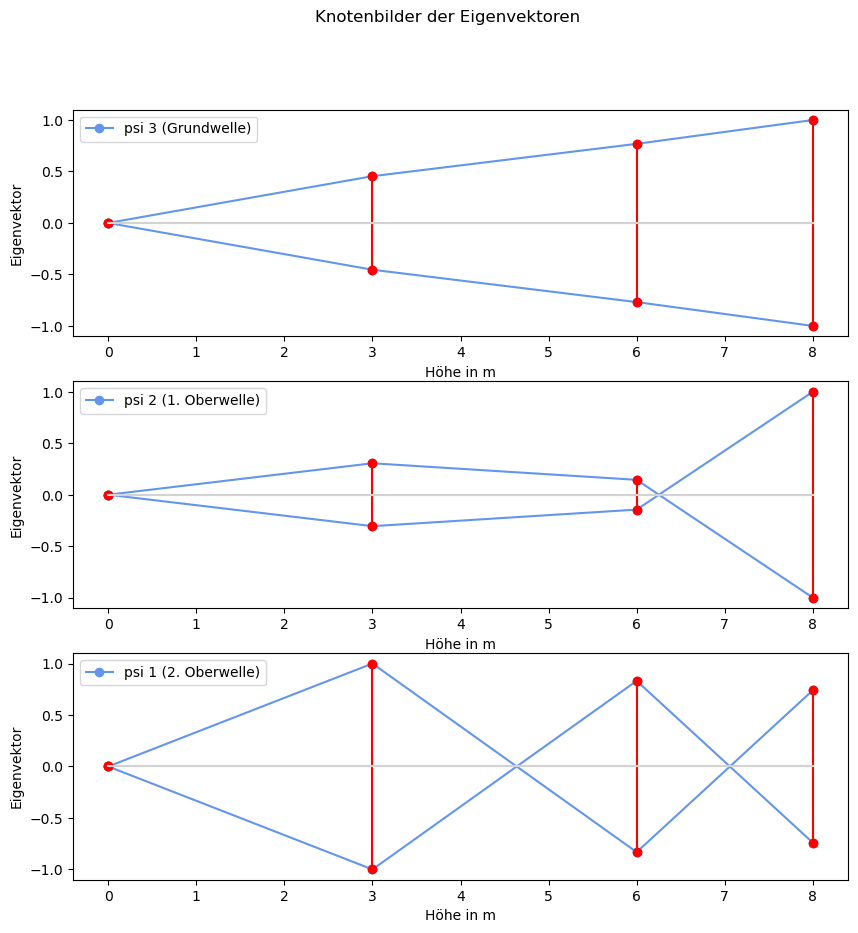

In [201]:
x = np.arange(ordnung+1)
x = np.array([0, 3, 6, 8])  # Orte der darzustellenden Eigenvektoren
psi_1 = psi[:,0]
psi_2 = psi[:,1]
psi_3 = psi[:,2]
nullvektor = np.zeros(1)
y1 = np.insert(psi_1,0,0)
y2 = np.insert(psi_2,0,0)
y3 = np.insert(psi_3,0,0)

# Plot Knotenbild (mode shape)
fig, axs = plt.subplots(3, 1,figsize=(10,10))
fig.suptitle('Knotenbilder der Eigenvektoren')

axs[0].plot(x,y3, 'o-', color='cornflowerblue',label="psi 3 (Grundwelle)")
axs[0].legend(loc=2)
axs[0].set_xlabel('Höhe in m')
axs[0].set_ylabel('Eigenvektor')
axs[0].plot(x, -y3,'o-', color='cornflowerblue')
axs[0].stem(x,y3, linefmt='red', basefmt='lightgray')
axs[0].stem(x,-y3, linefmt='red', basefmt='lightgray')

axs[1].plot(x,y2, 'o-', color='cornflowerblue',label="psi 2 (1. Oberwelle)")
axs[1].legend(loc=2)
axs[1].set_xlabel('Höhe in m')
axs[1].set_ylabel('Eigenvektor')
axs[1].plot(x,-y2,'o-', color='cornflowerblue')
axs[1].stem(x,y2, linefmt='red', basefmt='lightgray')
axs[1].stem(x,-y2, linefmt='red', basefmt='lightgray')

axs[2].plot(x,y1, 'o-', color='cornflowerblue',label="psi 1 (2. Oberwelle)")
axs[2].legend(loc=2)
axs[2].set_xlabel('Höhe in m')
axs[2].set_ylabel('Eigenvektor')
axs[2].plot(x,-y1,'o-', color='cornflowerblue')
axs[2].stem(x,y1, linefmt='red', basefmt='lightgray')
axs[2].stem(x,-y1, linefmt='red', basefmt='lightgray')

plt.show()

### Lösung der entkoppelten Gleichungen im Zeitbereich 

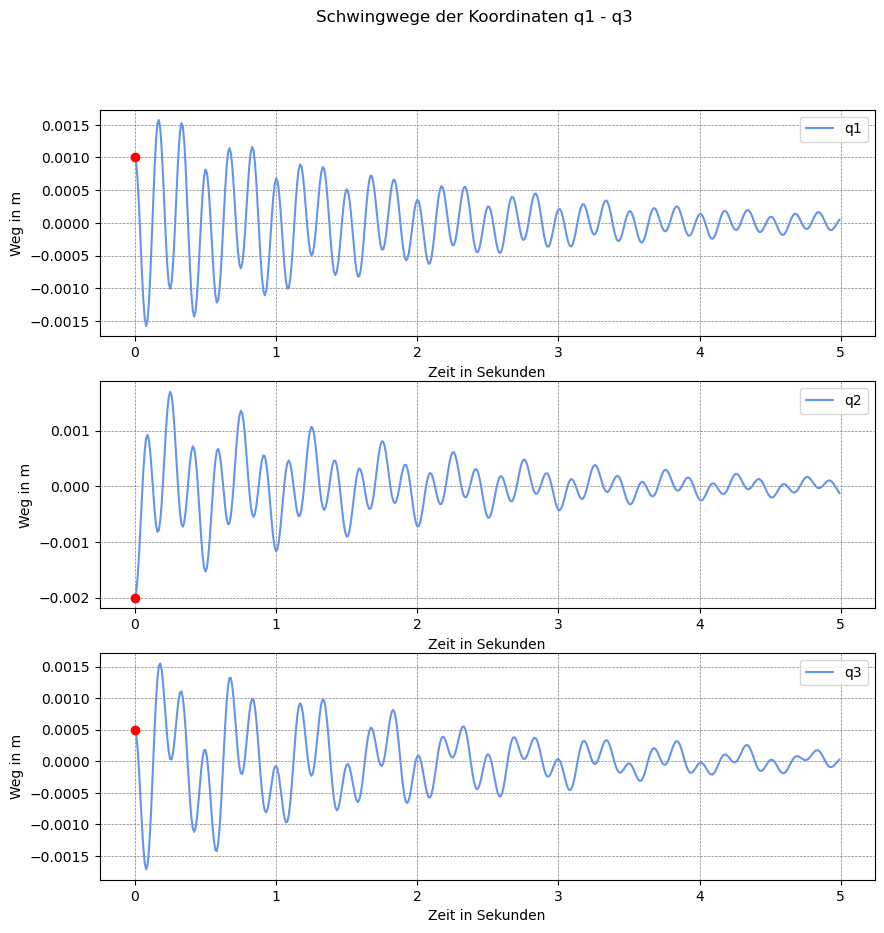

In [202]:
# Lösung im Zeitbereich über modale Entkopplung

# modale Transformation der Anfangsbedingungen
p_0 = np.dot(np.linalg.inv(phi), q_0)  # Anfangsweg im Modalraum
v_0p = np.dot(np.linalg.inv(phi), v_0)  # Anfangsgeschwindigkeit im Modalraum
C_1 = p_0  # modale Integrationskonstante C1
C_2 = (v_0p + delta * C_1) / wd  # modale Integrationskonstante C2

t = np.arange(0, 5, 0.01)  # Zeitreife für Darstellung

# Schwingwege im Modalraum
p_1 = np.exp(-delta[0] * t) * (C_1[0] * np.cos(wn[0] * t) + C_2[0] * np.sin(wn[0] * t))
p_2 = np.exp(-delta[1] * t) * (C_1[1] * np.cos(wn[1] * t) + C_2[1] * np.sin(wn[1] * t))
p_3 = np.exp(-delta[2] * t) * (C_1[2] * np.cos(wn[2] * t) + C_2[2] * np.sin(wn[2] * t))

# Rücktransformation durch Superposition in den realen physikalischen Raum
q_1 = phi[0,0] * p_1 + phi[0,1] * p_2 + phi[0,2] * p_3
q_2 = phi[1,0] * p_1 + phi[1,1] * p_2 + phi[1,2] * p_3
q_3 = phi[2,0] * p_1 + phi[2,1] * p_2 + phi[2,2] * p_3

# Lösungen im Zeitbereich grafisch darstellen
fig, axs = plt.subplots(3, 1,figsize=(10,10))
fig.suptitle('Schwingwege der Koordinaten q1 - q3')

axs[0].plot(t, q_1, '-', color='cornflowerblue',label="q1")
axs[0].legend(loc='upper right')
axs[0].set_xlabel('Zeit in Sekunden')
axs[0].set_ylabel('Weg in m')

axs[1].plot(t, q_2, '-', color='cornflowerblue',label="q2")
axs[1].legend(loc='upper right')
axs[1].set_xlabel('Zeit in Sekunden')
axs[1].set_ylabel('Weg in m')

axs[2].plot(t, q_3, '-', color='cornflowerblue',label="q3")
axs[2].legend(loc='upper right')
axs[2].set_xlabel('Zeit in Sekunden')
axs[2].set_ylabel('Weg in m')

# Zeige ein Gitternetz im Hintergrund an
for ax in axs:
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Markierung der Anfangswege
axs[0].scatter(0,q_0[0], color='red', zorder=5)
axs[1].scatter(0,q_0[1], color='red', zorder=5)
axs[2].scatter(0,q_0[2], color='red', zorder=5)

plt.show()

### Frequenzgangmatrix berechnen und darstellen

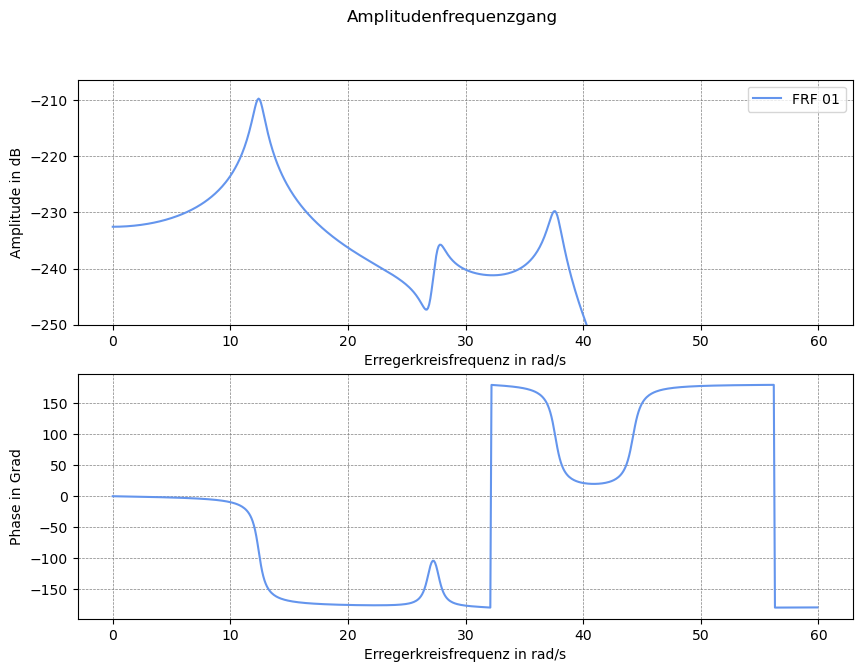

In [203]:
# Frequenzgangmatrix

# Residuum berechnen
Residuum = np.zeros(ordnung, dtype=complex) # erzeuge komplexen Null-Vektor
for i in range(ordnung):
    Residuum[i] = -1j / (2 * wd[i] * M[i, i])

# komplexe Eigenwerte berechnen
eigenwert_k = -delta + 1j * wd

# Erregerkreisfrequenz
omega_e = np.arange(0, 60, 0.1)

# Wahl des Frequenzgangmatrixelementes zur Berechnung und Darstellung
out_frf = 0
in_frf = 1

frequenzgang = frf(ordnung, out_frf, in_frf, omega_e)
amplitude = 20*np.log10(np.abs(frequenzgang))  # Amplitude in dB
phase_radian = np.angle(frequenzgang)
phase_degree = np.degrees(phase_radian)

# Plot Amplitudenfrequenzgang
fig, axs = plt.subplots(2, 1,figsize=(10,7))
fig.suptitle('Amplitudenfrequenzgang')
#axs[0].set_yscale("log")
axs[0].set_xlabel('Erregerkreisfrequenz in rad/s')
axs[0].set_ylabel('Amplitude in dB')
axs[0].plot(omega_e, amplitude, '-', color='cornflowerblue',
            label='FRF '+ str(out_frf) + str(in_frf))
axs[0].set_ylim(-250)
axs[0].legend(loc='upper right')

#axs[1].set_ylim(-180)
axs[1].set_xlabel('Erregerkreisfrequenz in rad/s')
axs[1].set_ylabel('Phase in Grad')
axs[1].plot(omega_e, phase_degree, '-', color='cornflowerblue')

multi = MultiCursor(fig.canvas, (axs[0], axs[1]), color='g', lw=2,
                    horizOn=True, vertOn=True)
# Zeige ein Gitternetz im Hintergrund an
for ax in axs:
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

plt.show()